In [1]:
import os
import torch
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader
from neuralhydrology.modelzoo import get_model
from neuralhydrology.utils.config import Config
import matplotlib.pyplot as plt
from tqdm import tqdm
import xarray as xr

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set random seed for reproducibility
torch.manual_seed(42)

# Results settings
data_folder = "data/CRB_flashy_highNSE/highnse/timeseries"
time_series_id = "14354185210"
results_folder = os.path.join("results/CRB_flashy_highNSE/highnse/timeseries", time_series_id, "lstm")

figsize = (8, 6)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20  # Change this value to your desired font size

### Load data ###

In [2]:
# Open the .nc file
ds = xr.open_dataset(os.path.join(data_folder, time_series_id + ".nc"))

# Get the list of variable names, excluding 'q_quality'
var_names = [var for var in ds.data_vars if var != 'q_quality']

# Create a list to store the data arrays
data_arrays = []
v = None

# Iterate through the selected variables
for var_name in var_names:
    # Skip variables with '_min_' or '_max_' in their names
    if '_min_' in var_name or '_max_' in var_name:
        print(f"{var_name} (skipped)")
        continue

    if var_name == 'q_mmday':
        # Handle q_mmday separately
        v = torch.from_numpy(ds[var_name].values)[0:4000]
    else:
        # Append the variable data
        data_arrays.append(torch.from_numpy(ds[var_name].values))
        print(var_name)

# Stack the tensors to create a 2D tensor
data = torch.stack(data_arrays).t()

# Close the dataset
ds.close()

raw_X = data[0:4000]
n = raw_X.shape[0]
d = raw_X.shape[1]
i = torch.arange(n)
dt = 1.

print(raw_X.shape)

dewpoint_temperature_2m__min__era5l_daily (skipped)
dewpoint_temperature_2m__max__era5l_daily (skipped)
dewpoint_temperature_2m__mean__era5l_daily
potential_evaporation__sum__era5l_daily
snow_depth_water_equivalent__min__era5l_daily (skipped)
snow_depth_water_equivalent__max__era5l_daily (skipped)
snow_depth_water_equivalent__mean__era5l_daily
surface_net_solar_radiation__min__era5l_daily (skipped)
surface_net_solar_radiation__max__era5l_daily (skipped)
surface_net_solar_radiation__mean__era5l_daily
surface_net_thermal_radiation__min__era5l_daily (skipped)
surface_net_thermal_radiation__max__era5l_daily (skipped)
surface_net_thermal_radiation__mean__era5l_daily
surface_pressure__min__era5l_daily (skipped)
surface_pressure__max__era5l_daily (skipped)
surface_pressure__mean__era5l_daily
temperature_2m__min__era5l_daily (skipped)
temperature_2m__max__era5l_daily (skipped)
temperature_2m__mean__era5l_daily
total_precipitation__sum__era5l_daily
u_component_of_wind_10m__min__era5l_daily (ski

In [3]:
# data cleaning

def interpolate_and_handle_outliers(X, outlier_threshold=4):
    """
    Interpolate NaN values and handle outliers in a 2D PyTorch tensor.
    
    Args:
    X (torch.Tensor): Input tensor of shape (n, m) where n is the data dimension and m is the number of features.
    outlier_threshold (float): Multiplier for the median norm to determine outliers.
    
    Returns:
    torch.Tensor: Processed tensor with interpolated values and handled outliers.
    """
    n, m = X.shape
    X_processed = X.clone()

    # Calculate the norm for each time step, ignoring NaNs
    norms = torch.sqrt(torch.nansum(X**2, dim=1))
    median_norm = torch.nanmedian(norms)

    # Identify NaN and outlier positions
    is_nan = torch.isnan(X)
    is_outlier = norms > (outlier_threshold * median_norm)

    # Iterate over each data point
    for i in range(n):
        if is_nan[i].any() or is_outlier[i]:
            # Find previous and next valid indices
            prev_idx = next((j for j in range(i - 1, -1, -1) if not is_nan[j].any() and not is_outlier[j]), None)
            next_idx = next((j for j in range(i + 1, n) if not is_nan[j].any() and not is_outlier[j]), None)

            if prev_idx is not None and next_idx is not None:
                # Linear interpolation between previous and next valid points
                X_processed[i] = (X[prev_idx] + X[next_idx]) / 2
            elif prev_idx is not None:
                # Use previous valid point if no next valid point
                X_processed[i] = X[prev_idx]
            elif next_idx is not None:
                # Use next valid point if no previous valid point
                X_processed[i] = X[next_idx]
            else:
                # If no valid points are found, leave as NaN or handle as needed
                pass

    return X_processed

X = interpolate_and_handle_outliers(raw_X)
X /= X.max()
# X_mean = X.mean(0)
# X_std = X.std(0)
# X = (X - X_mean) / X_std

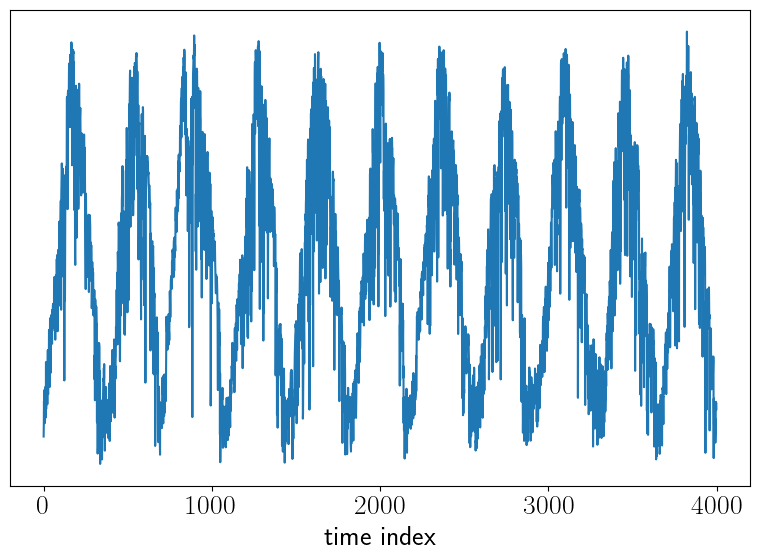

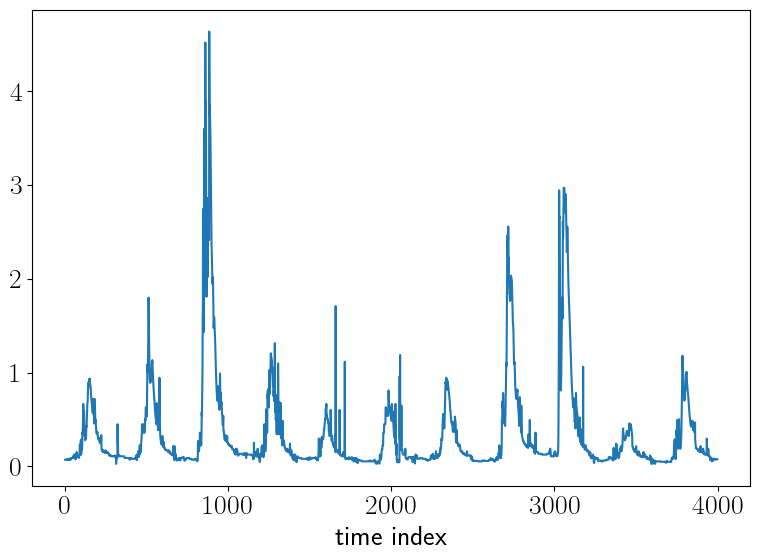

In [4]:
# Plot data dynamics
plt.figure(figsize=figsize)
plt.plot(range(n), X.norm(2,1))
plt.yticks([])  # Remove y-axis ticks
plt.xlabel("time index")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "x_data_norm.eps"))
plt.show()

# Plot signal
plt.figure(figsize=figsize)
plt.plot(i, v)
plt.xlabel("time index")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_data.eps"))
plt.show()

In [5]:
# split in train and validation
split = 0.8
n_ = int(split * n)
i_train = i[:n_].float()
X_train = X[:n_].float()
v_train = v[:n_].float()
i_val = i[n_:].float()
X_val = X[n_:].float()
v_val = v[n_:].float()

### Reconstruct using LSTM ###

In [6]:
config = Config(
    {
    'validate_every': 3, # specify after how many epochs to perform validation
    'validate_n_random_basins': 1, # specify how many random basins to use for validation
    'metrics': ['NSE'], # specify which metrics to calculate during validation (see neuralhydrology.evaluation.metrics)
    # --- Model configuration --------------------------------------------------------------------------
    'model': 'cudalstm', # base model type [lstm, ealstm, cudalstm, embcudalstm, mtslstm]
    'head': 'regression', # prediction head [regression]. Define the head specific parameters below
    'dynamic_inputs': ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14'],  # Feature names
    'target_variables': ['discharge'],
    # ----> Regression settings <----
    'output_activation': 'linear',  
    # ----> General settings <----
    'hidden_size': 20, # Number of cell states of the LSTM
    'initial_forget_bias': 3, # Initial bias value of the forget gate
    'output_dropout': 0.4, # Dropout applied to the output of the LSTM
    # --- Training configuration -----------------------------------------------------------------------
    'optimizer': 'Adam', # specify optimizer [Adam]
    'loss': 'MSE', # specify loss [MSE, NSE, RMSE]
    'learning_rate': {0: 1e-2, 30: 5e-3, 40: 1e-3}, # specify learning rates to use starting at specific epochs (0 is the initial learning rate)
    'batch_size': 256, # Mini-batch size
    'epochs': 50, # Number of training epochs
    'clip_gradient_norm': 1, # If a value, clips the gradients during training to that norm.
    'predict_last_n': 1, # Defines which time steps are used to calculate the loss. Can't be larger than seq_length.
    'seq_length': 365, # Length of the input sequence
    'num_workers': 1, # Number of parallel workers used in the data pipeline
    'log_interval': 5, # Log the training loss every n steps
    'log_tensorboard': False, # If true, writes logging results into tensorboard file
    'log_n_figures': 0., # If a value and greater than 0, logs n random basins as figures during validation
    'save_weights_every': 1, # Save model weights every n epochs
    }
)

In [7]:
class HydrologyDataset(Dataset):
    def __init__(self, x, v, window_size):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.v = torch.tensor(v, dtype=torch.float32)
        self.window_size = window_size

    def __len__(self):
        return len(self.x) - self.window_size + 1

    def __getitem__(self, idx):
        return {'x_d': self.x[idx:idx+self.window_size], 'y': self.v[idx+self.window_size-1]}

# Create the dataset
train_dataset = HydrologyDataset(X_train, v_train, config.seq_length)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test_dataset = HydrologyDataset(X, v, config.seq_length)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

/var/folders/ly/f4m8s6ks3w5cc8_y1dv124bc0000gn/T/ipykernel_4657/1881238587.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)
/var/folders/ly/f4m8s6ks3w5cc8_y1dv124bc0000gn/T/ipykernel_4657/1881238587.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.v = torch.tensor(v, dtype=torch.float32)


In [8]:
model = get_model(config).to(config.device)

In [9]:
# Extract initial learning rate from config dictionary
initial_lr = config.learning_rate[0]  # Get 1e-2 from {0: 1e-2, 30: 5e-3, 40: 1e-3}

# Create optimizer with initial learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

# Implement custom learning rate schedule
def lr_lambda(epoch):
    for key in sorted(config.learning_rate.keys(), reverse=True):
        if epoch >= key:
            return config.learning_rate[key] / initial_lr
    return 1.0

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
criterion = torch.nn.MSELoss()

for epoch in range(config.epochs):
    model.train()
    for batch in train_loader:  # Use standard batch unpacking
        optimizer.zero_grad()
        
        # NeuralHydrology 1.7 expects dictionary-style inputs
        x_d = batch['x_d'].to(config.device).float()
        y_true = batch['y'][:,None].to(config.device).float()

        # Forward pass (model expects dictionary input in older versions)
        output = model(batch)
        loss = criterion(output['y_hat'][:,-1], y_true)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_gradient_norm)
        optimizer.step()
    
    # Update learning rate according to schedule
    scheduler.step()
    
    print(f'Epoch {epoch+1}/{config.epochs} | Loss: {loss.item():.4f} | LR: {scheduler.get_last_lr()[0]:.5f}')

Epoch 1/50 | Loss: 0.0470 | LR: 0.01000
Epoch 2/50 | Loss: 0.2046 | LR: 0.01000
Epoch 3/50 | Loss: 0.2447 | LR: 0.01000
Epoch 4/50 | Loss: 0.2888 | LR: 0.01000
Epoch 5/50 | Loss: 0.0750 | LR: 0.01000
Epoch 6/50 | Loss: 0.2229 | LR: 0.01000
Epoch 7/50 | Loss: 0.2349 | LR: 0.01000
Epoch 8/50 | Loss: 0.0675 | LR: 0.01000
Epoch 9/50 | Loss: 0.0303 | LR: 0.01000
Epoch 10/50 | Loss: 0.0506 | LR: 0.01000
Epoch 11/50 | Loss: 0.0858 | LR: 0.01000
Epoch 12/50 | Loss: 0.1243 | LR: 0.01000
Epoch 13/50 | Loss: 0.0819 | LR: 0.01000
Epoch 14/50 | Loss: 0.0372 | LR: 0.01000
Epoch 15/50 | Loss: 0.0546 | LR: 0.01000
Epoch 16/50 | Loss: 0.0341 | LR: 0.01000
Epoch 17/50 | Loss: 0.4191 | LR: 0.01000
Epoch 18/50 | Loss: 0.0696 | LR: 0.01000
Epoch 19/50 | Loss: 0.0764 | LR: 0.01000
Epoch 20/50 | Loss: 0.0169 | LR: 0.01000
Epoch 21/50 | Loss: 0.0282 | LR: 0.01000
Epoch 22/50 | Loss: 0.1501 | LR: 0.01000
Epoch 23/50 | Loss: 0.1002 | LR: 0.01000
Epoch 24/50 | Loss: 0.2515 | LR: 0.01000
Epoch 25/50 | Loss: 0.090

In [10]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for batch in loader:
            
            output = model(batch)
            y_pred = output['y_hat'].cpu()
            
            all_preds.append(y_pred[:,-1])
    
    preds = torch.cat(all_preds).squeeze()
    return preds

# For test set (final evaluation)
v_net = torch.zeros_like(v)
v_net[config.seq_length-1:] = evaluate_model(model, test_loader)

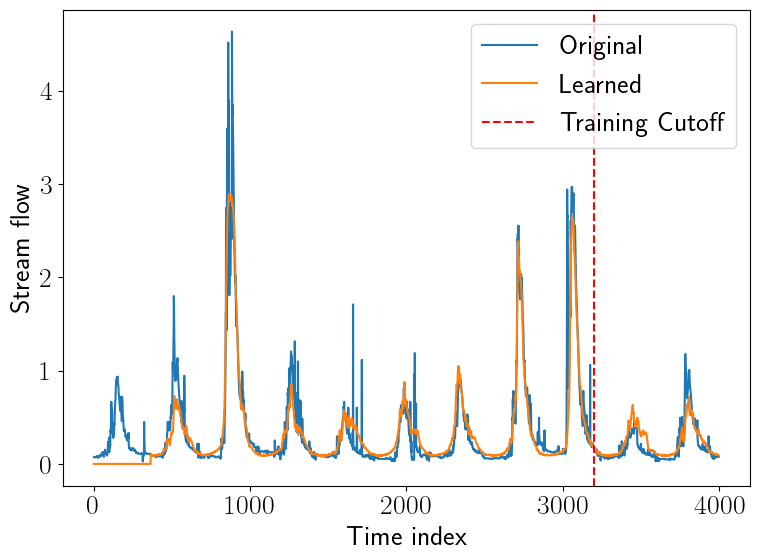

In [11]:
# Plot learned signal
plt.figure(figsize=figsize)
plt.plot(i, v, label='Original')
plt.plot(i, v_net, label='Learned')
plt.axvline(x=i_train[-1], color='r', linestyle='--', label='Training Cutoff')
plt.legend(loc='upper right')
plt.xlabel("Time index")
plt.ylabel("Stream flow")
plt.tight_layout()
plt.show()

In [12]:
# define NSE metric
def nse(original, predicted):
    
    if original.shape != predicted.shape:
        raise ValueError("Input tensors must have the same shape")
    
    mean_observed = torch.mean(original)
    numerator = torch.sum((original - predicted) ** 2)
    denominator = torch.sum((original - mean_observed) ** 2)

    return 1 - (numerator / denominator)

In [13]:
# Compute NSE metrics
total_nse = nse(v[config.seq_length-1:], v_net[config.seq_length-1:])

# Training NSE
train_nse = nse(v[config.seq_length-1:int(i_train[-1].item())+1], v_net[config.seq_length-1:int(i_train[-1].item())+1])

# Validation NSE
val_nse = nse(v[int(i_train[-1].item())+1:], v_net[int(i_train[-1].item())+1:])

print(f"Total NSE = {total_nse} | NSE on training data = {train_nse} | NSE on validation data = {val_nse}")

Total NSE = 0.8784429456224794 | NSE on training data = 0.8827950564503443 | NSE on validation data = 0.6596647040441497
